In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pickle
from future_grid import FutureDemand

In [5]:
unit_drops = pd.read_csv('IntermediateOutputs/scheduled_retirements_2019.csv', index_col=0)
additions_df = pd.read_csv('IntermediateOutputs/generator_additions.csv', index_col=0)
import copy
def drop_add_generators(future_year, gd_short_init, unit_drops=None, additions_df=None, drop=True, add=True):
    
    gd_short_final = copy.deepcopy(gd_short_init)
    if add:
        added_units = additions_df[additions_df['Year']<future_year]['orispl_unit'].values
        for i, val in enumerate(added_units):
            idx = len(gd_short_final.df)
            loc1 = gd_short_final.df[gd_short_final.df['orispl_unit']==val].index
            gd_short_final.df = pd.concat((gd_short_final.df, gd_short_final.df.loc[loc1]), ignore_index=True)
            gd_short_final.df.loc[idx, 'orispl_unit'] = 'added_'+str(i)
        
    if drop:
        dropped_units = unit_drops[unit_drops['retirement_year']<future_year]['orispl_unit'].values
        gd_short_final.df = gd_short_final.df[~gd_short_final.df['orispl_unit'].isin(dropped_units)].copy(deep=True).reset_index(drop=True)
    
    return gd_short_final

In [8]:
year = 2030; solar = 2.5; wind = 2.5; run_year=2019
gd_short = pickle.load(open('IntermediateOutputs/generator_data_short_%s_%s.obj'%('WECC', str(run_year)), 'rb'))
gd_short_copy = drop_add_generators(year, gd_short, drop=True, unit_drops=unit_drops, add=True, additions_df=additions_df)
future = FutureDemand(gd_short_copy, year=year)
future.electrification(scale_vs_given=True)
future.solar_multiplier[year] = solar
future.wind_multiplier[year] = wind
future.solar()
future.wind()
future.update_total()
mean_weekday = future.demand[pd.to_datetime(future.demand['datetime']).dt.weekday.isin([0, 1, 2, 3, 4])]['total_incl_noncombustion'].values.reshape(-1, 24).mean(axis=0)

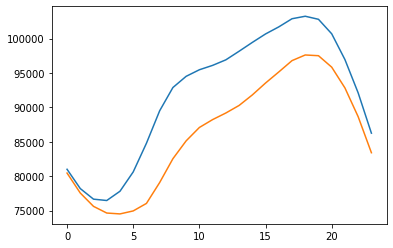

In [9]:
mean_weekend = future.demand[pd.to_datetime(future.demand['datetime']).dt.weekday.isin([5, 6])]['total_incl_noncombustion'].values.reshape((-1, 24)).mean(axis=0)
plt.plot(mean_weekday)
plt.plot(mean_weekend)
plt.show()

In [11]:
pd.DataFrame({'Mean Weekday NoEVs 2030':mean_weekday, 'Mean Weekend NoEVs 2030':mean_weekend}).to_csv('IntermediateOutputs/mean_days_noEVs.csv')